# $$ Monte Carlo - First Visit - VFA $$

## Imports

In [1]:
# imports from libs
import sys
import numpy as np
import math
import random
import gym
import gym_maze
import os
from collections import defaultdict

# imports from project
from utils.plotting import plot_line_graphs_overlayed
from utils.file_management import create_folder_structure
from utils.file_management import save_nparray_to_folder

## Setting Saving Directory

In [2]:
cwd = os.getcwd()
SAVING_RESULTS_FODLER = os.path.join(cwd,"results","MC_First_Visit_VFA")
SAVING_RESULTS_FODLER

'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\MC_First_Visit_VFA'

## Constants

In [3]:
# Initialize the "maze" environment
env = gym.make("maze-v0")

'''
Defining the environment related constants
'''
# Number of discrete states (bucket) per state dimension
MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
NUM_BUCKETS = MAZE_SIZE  # one bucket per grid

# Number of discrete actions
NUM_ACTIONS = env.action_space.n  # ["N", "S", "E", "W"]
# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))

'''
Learning related constants
'''
MIN_EXPLORE_RATE = 0.001
DECAY_FACTOR = np.prod(MAZE_SIZE, dtype=float) / 10.0

'''
Defining the simulation related constants
'''
NUM_EPISODES = 300
MAX_T = np.prod(MAZE_SIZE, dtype=int) * 100
STREAK_TO_END = 100
SOLVED_T = np.prod(MAZE_SIZE, dtype=int)
RENDER_MAZE = False
ENABLE_RECORDING = False

'''
Q-Learning Related Constants
'''
DISCOUNT_FACTOR = 0.99

'''
CREATING RESULTS SAVING FOLDERS
'''
SAVING_RESULTS_IMAGE_FODLER = os.path.join(SAVING_RESULTS_FODLER,"images")
SAVING_RESULTS_VIDEO_FODLER = os.path.join(SAVING_RESULTS_FODLER,"videos")
SAVING_RESULTS_ARRAY_FODLER = os.path.join(SAVING_RESULTS_FODLER,"arrays")
create_folder_structure(SAVING_RESULTS_IMAGE_FODLER)
create_folder_structure(SAVING_RESULTS_VIDEO_FODLER)
create_folder_structure(SAVING_RESULTS_ARRAY_FODLER)

'''
ENABLE RECORDING
'''
if ENABLE_RECORDING:
    env = gym.wrappers.Monitor(env,SAVING_RESULTS_VIDEO_FODLER, force=True)

pygame 2.0.1 (SDL 2.0.14, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Algorithm Simulation

In [4]:
def simulate(discount_factor:float= 0.99):
    """Simulate Q-Learning Algorythim .

    Args:
        discount_factor (float): gamma.

    Returns:
        np.array(reward_episode_list): Numpy array with the episodes rewards
        np.array(explore_rate_episode_list): Numpy array with the episodes explore rates
        np.array(num_streaks_episode_list): Numpy array with the episodes number of mazze completions
        np.array(length_episode_list): Numpy array with the episodes lengths
    """

    #Defining Feature Vector
    X = np.zeros((MAZE_SIZE[0]*MAZE_SIZE[1] , MAZE_SIZE[0]*MAZE_SIZE[1], 4))

    X[:,:,0] = np.identity(MAZE_SIZE[0]*MAZE_SIZE[1]) # Vetor de estados para ação 0
    X[:,:,1] = np.identity(MAZE_SIZE[0]*MAZE_SIZE[1]) # Vetor de estados para ação 1
    X[:,:,2] = np.identity(MAZE_SIZE[0]*MAZE_SIZE[1]) # Vetor de estados para ação 2
    X[:,:,3] = np.identity(MAZE_SIZE[0]*MAZE_SIZE[1]) # Vetor de estados para ação 3


    #Defining q_hat (oraculo)
    q_hat = defaultdict(lambda: np.zeros(env.action_space.n))
    
    #Defining wights
    weights = np.zeros(MAZE_SIZE[0]*MAZE_SIZE[1])

    #creating episodes results lists
    
    reward_episode_list = []
    explore_rate_episode_list = []
    num_streaks_episode_list = []
    length_episode_list = []

    # Instantiating the related par ameters
    explore_rate = get_explore_rate(0)

    # Render tha maze
    env.render()

    #Initializain num streaks
    num_streaks= 0


    for episode in range(NUM_EPISODES):
        # Episode Reinitialization
        total_reward = 0
        G_t = 0

        # Sample k-th episode (sk,1, ak,1, rk,1, sk,2, . . . , sk,T ) given πk
        obv = env.reset()
        state = state_to_bucket(obv)
        episode_array = []
        for t in range(MAX_T):
            action = epsilon_greedy_police(state, explore_rate,q_hat)
            obv, reward, done, _ = env.step(action)
            next_state = state_to_bucket(obv)
            total_reward += reward
            episode_array.append((state, action, reward)) # tuple transforma array([0,0]) em (0,0)

            # Render tha maze
            if RENDER_MAZE:
                env.render()

            if env.is_game_over():
                sys.exit()


            if done:
                print(f"Episode {episode} finished after {t} time steps with total reward = {total_reward} (streak {num_streaks}).")

                if t <= SOLVED_T:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= MAX_T - 1:
                print(f"Episode {episode} timed out at {t} with total reward = {total_reward}.")

            state = next_state
        
        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode_array])
        for s, a in sa_in_episode:
            sa_pair = (s, a)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode_array) if x[0] == s and x[1] == a)

            # Sum up all rewards since the first occurance
            G_t = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode_array[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            weights += (G_t - np.dot( X[:,MAZE_SIZE[0]*s[0]+s[1], a], weights) * X[:,MAZE_SIZE[0]*s[0]+s[1], a])
                        
            q_hat[s][a] += np.dot( X[:,MAZE_SIZE[0]*s[0]+s[1], a], weights)


        # Appending Episode values to the list
        reward_episode_list.append(total_reward)
        explore_rate_episode_list.append(explore_rate)
        num_streaks_episode_list.append(num_streaks)
        length_episode_list.append(t)

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)


    return (np.array(reward_episode_list),
            np.array(explore_rate_episode_list),
            np.array(num_streaks_episode_list),
            np.array(length_episode_list))


## Epsilon Greed Exploration

In [5]:
def epsilon_greedy_police(state, explore_rate,q_hat):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_hat[state]))
    return action

## Updating EXPLORE_RATE

In [6]:
def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))

## Function that returns the actual state

In [7]:
def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

## Running

In [8]:
reward_episode_array,explore_rate_episode_array,num_streaks_episode_array,length_episode_array = \
        simulate(discount_factor = DISCOUNT_FACTOR)

if ENABLE_RECORDING:
    env.monitor.close()

Episode 0 finished after 1429 time steps with total reward = -4.715999999999814 (streak 0).
Episode 1 finished after 235 time steps with total reward = 0.059999999999999276 (streak 0).
Episode 2 finished after 244 time steps with total reward = 0.023999999999999244 (streak 0).
Episode 3 finished after 1487 time steps with total reward = -4.947999999999788 (streak 0).
Episode 4 finished after 68 time steps with total reward = 0.7279999999999998 (streak 0).
Episode 5 finished after 143 time steps with total reward = 0.4279999999999996 (streak 0).
Episode 6 finished after 66 time steps with total reward = 0.7359999999999998 (streak 0).
Episode 7 finished after 117 time steps with total reward = 0.5319999999999996 (streak 0).
Episode 8 finished after 36 time steps with total reward = 0.8559999999999999 (streak 0).
Episode 9 finished after 57 time steps with total reward = 0.7719999999999998 (streak 0).
Episode 10 finished after 16 time steps with total reward = 0.9359999999999999 (streak 0

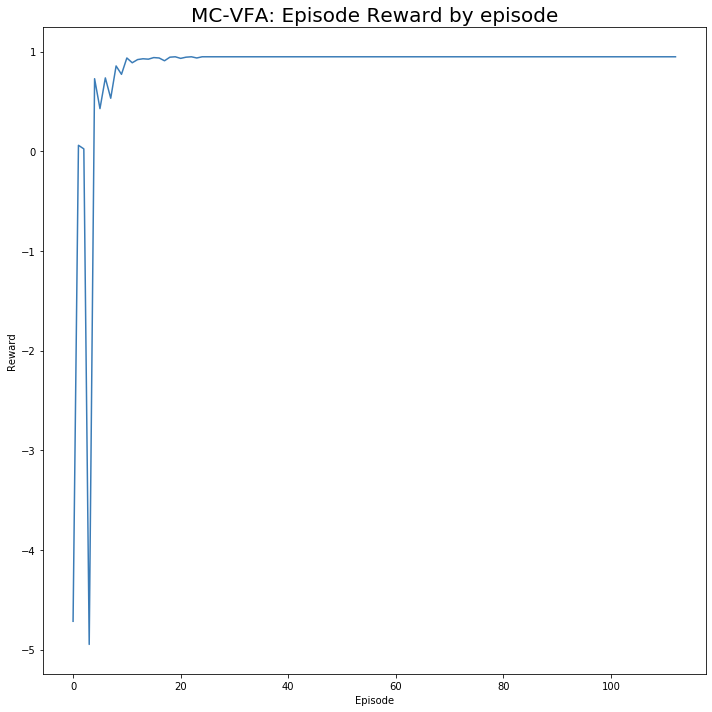

<Figure size 432x288 with 0 Axes>

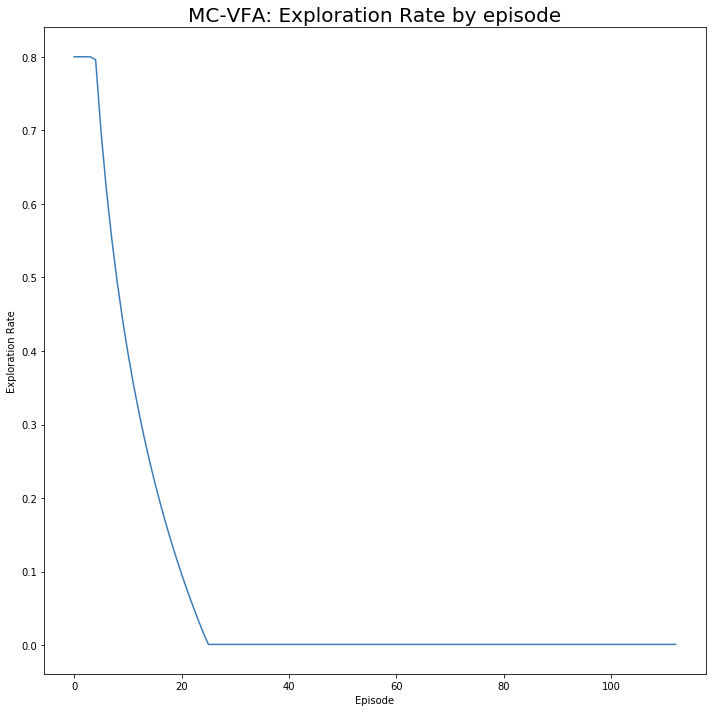

<Figure size 432x288 with 0 Axes>

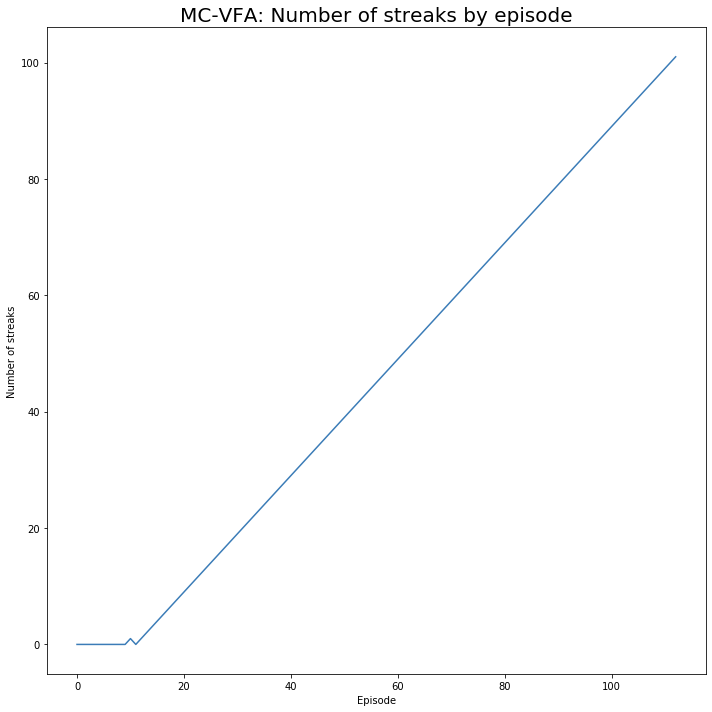

<Figure size 432x288 with 0 Axes>

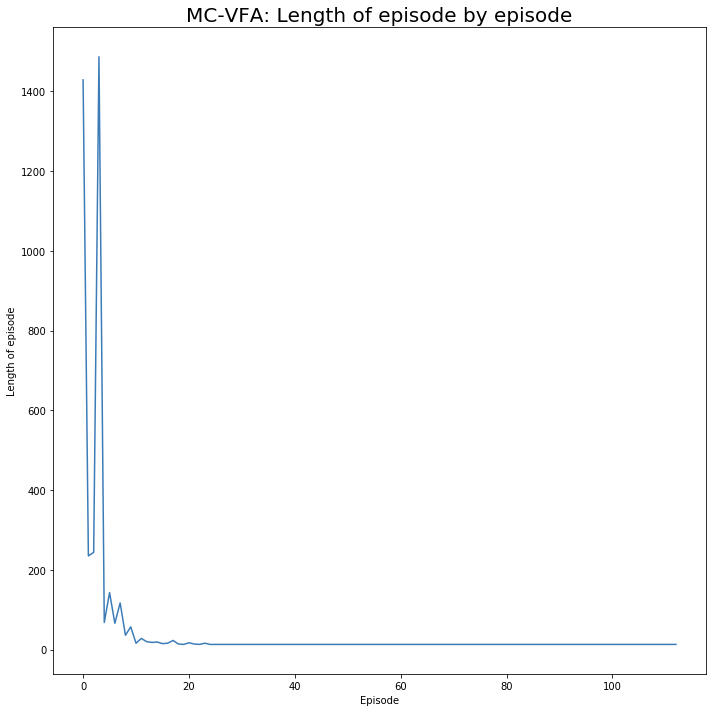

<Figure size 432x288 with 0 Axes>

In [9]:
graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"reward_episode")
plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [reward_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Reward",
                            legends = ["None_Marker"],
                            title = "MC-VFA: Episode Reward by episode" ,
                            graph_saving_path = graph_saving_path)


graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"explore_rate_episode")
plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [explore_rate_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Exploration Rate",
                            legends = ["None_Marker"],
                            title = "MC-VFA: Exploration Rate by episode" ,
                            graph_saving_path = graph_saving_path)



graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"num_streaks_episode")
plot_line_graphs_overlayed(x_list =[range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [num_streaks_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Number of streaks",
                            legends = ["None_Marker"],
                            title = "MC-VFA: Number of streaks by episode" ,
                            graph_saving_path = graph_saving_path)


graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"length_episode")
plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [length_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Length of episode",
                            legends = ["None_Marker"],
                            title = "MC-VFA: Length of episode by episode" ,
                            graph_saving_path = graph_saving_path)

## Saving numpy arrays from results

In [10]:
save_nparray_to_folder(reward_episode_array,SAVING_RESULTS_ARRAY_FODLER,"reward_episode")
save_nparray_to_folder(explore_rate_episode_array,SAVING_RESULTS_ARRAY_FODLER,"explore_rate")
save_nparray_to_folder(num_streaks_episode_array,SAVING_RESULTS_ARRAY_FODLER,"num_streaks")
save_nparray_to_folder(length_episode_array,SAVING_RESULTS_ARRAY_FODLER,"length_episode")

reward_episode Shape:  (113,)
explore_rate Shape:  (113,)
num_streaks Shape:  (113,)
length_episode Shape:  (113,)
